I used the Relative Strength Index (RSI) to algorithmically develop buy and sell signals for Facebook and Microsoft stocks over a 11 month time period

RSI is a common momentum indicator used in technical analysis. Stocks 
RSI values below 30 are oversold or undervalued while stocks with RSI value above 70 are overbought or overvalued. A RSI of 50 is considered a neutral level. 

Bullish behaviors(stock price predicted to increase) occur when the RSI breaks the 30 level from under to above. On the other hand, bearish behaviors(stock price predicted to decrease) occur when the RSI breaks the 70 level from above to under. 

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import requests
import matplotlib.pyplot as plt
import yfinance
from datetime import date

Used the yfinance API to obtain historical stock data for Facebook and Microsoft

Note: only takes about 176 ms to obtain 238 records; therefore, API has better runtime effeciency than data scrapping.

In [2]:
%%time
fb_stock = yfinance.download('FB', start='2020-06-29', end='2021-06-29', interval='1d')

[*********************100%***********************]  1 of 1 completed
CPU times: user 22.1 ms, sys: 19.9 ms, total: 42 ms
Wall time: 176 ms


In [3]:
msft_stock = yfinance.download('MSFT', start='2020-06-29', end='2021-06-29', interval='1d')

[*********************100%***********************]  1 of 1 completed


Ensure that stock data does not contain any null values

In [4]:
fb_stock[fb_stock.isnull().values]
msft_stock[fb_stock.isnull().values]

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


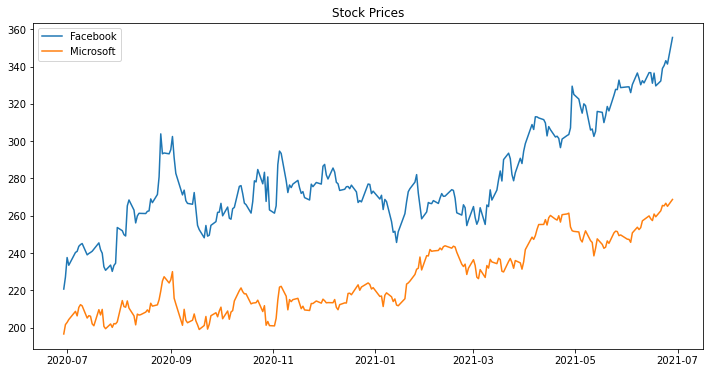

In [5]:
plt.figure(figsize=(12, 6))
plt.title('Stock Prices')
plt.plot(fb_stock.index, fb_stock['Adj Close'])
plt.plot(msft_stock.index, msft_stock['Adj Close'])
plt.legend(['Facebook', 'Microsoft'])

In [6]:
def get_rsi(stock_df, period):
    change = stock_df['Adj Close'].diff()
    change.dropna()
    gain = change.copy()
    gain[gain < 0] = 0
    loss = change.copy()
    loss[loss > 0] = 0
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = abs(loss.rolling(window=period).mean())
    rs = avg_gain/avg_loss
    rsi = 100 - (100 / (1 + rs))
    rsi = rsi.dropna()
    return rsi

In [7]:
fb_rsi = get_rsi(fb_stock, 14)
msft_rsi = get_rsi(msft_stock, 14)

Accounts for the NAN values when calculating the RSI index due to rolling averages so that both the RSI and stock price graphs line up in the x-axis(date)

In [8]:
fb_stock = fb_stock.loc[fb_stock.index >= pd.to_datetime('2020-07-20')]
msft_stock = msft_stock.loc[msft_stock.index >= pd.to_datetime('2020-07-20')]

In [9]:
fb_stock.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-20,240.059998,246.050003,235.639999,245.419998,245.419998,20872200
2020-07-21,246.220001,246.910004,240.080002,241.750000,241.750000,19364200
2020-07-22,240.259995,241.899994,238.119995,239.869995,239.869995,15427900
2020-07-23,239.630005,242.419998,231.750000,232.600006,232.600006,21771800
2020-07-24,230.190002,233.490005,226.899994,230.710007,230.710007,18325800


In [10]:
msft_stock.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-20,205.000000,212.300003,203.009995,211.600006,209.570831,36884800
2020-07-21,213.660004,213.940002,208.029999,208.750000,206.748154,37990400
2020-07-22,209.199997,212.300003,208.389999,211.750000,209.719360,49605700
2020-07-23,207.190002,210.919998,202.149994,202.539993,200.597687,67457000
2020-07-24,200.419998,202.860001,197.509995,201.300003,199.369598,39827000


Identifies buy and sell points based on rsi algorithmn. Limits the program to only buy one stock at a time

In [11]:
def buy_sell_indicators(df, rsi):
    buy_points = []
    sell_points = []
    stock_status = 0
    transaction_history = []
    transaction_history_price = []
    profit = 0
    for index in range(0, len(df)):
        if index != 0 and rsi[index] > 30 and rsi[index-1]<=30 and stock_status != 1:
            buy_points.append(df['Adj Close'][index])
            profit -= df['Adj Close'][index]
            sell_points.append(np.nan)
            transaction_history.append('Buy') 
            transaction_history_price.append(df['Adj Close'][index])
            stock_status = 1
        elif index != 0 and rsi[index] < 70 and rsi[index-1]>=70 and stock_status != 2 and stock_status != 0:
            buy_points.append(np.nan)
            profit += df['Adj Close'][index]
            sell_points.append(df['Adj Close'][index])
            transaction_history.append('Sell') 
            transaction_history_price.append(df['Adj Close'][index])
            stock_status = 2
        else:
            buy_points.append(np.nan)
            sell_points.append(np.nan)
    if transaction_history.count('Buy') > transaction_history.count('Sell'):
        profit += transaction_history_price[-1]
    return buy_points, sell_points, profit

In [12]:
fb_stock['Buy'] = buy_sell_indicators(fb_stock, fb_rsi)[0]
fb_stock['Sell'] = buy_sell_indicators(fb_stock, fb_rsi)[1]
fb_stock_profit = buy_sell_indicators(fb_stock, fb_rsi)[2]

In [13]:
msft_stock['Buy'] = buy_sell_indicators(msft_stock, msft_rsi)[0]
msft_stock['Sell'] = buy_sell_indicators(msft_stock, msft_rsi)[1]
msft_stock_profit = buy_sell_indicators(msft_stock, msft_rsi)[2]

In [14]:
print('The Facebook stock earned a profit of ' + '${:,.2f}'.format(fb_stock_profit) + ' using the RSI')
print('The Microsoft stock earned a profit of ' + '${:,.2f}'.format(msft_stock_profit) + ' using the RSI')

The Facebook stock earned a profit of $31.03 using the RSI
The Microsoft stock earned a profit of $69.37 using the RSI


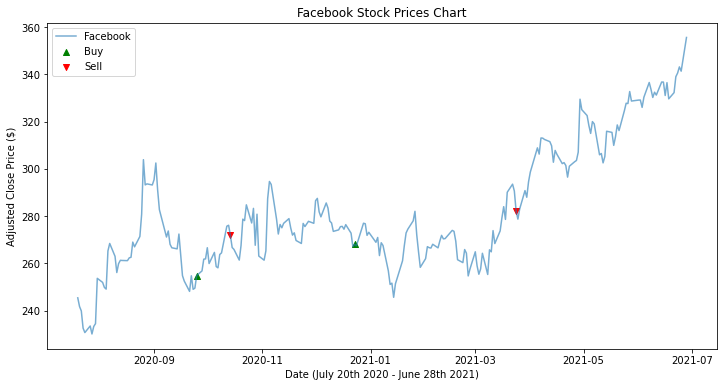

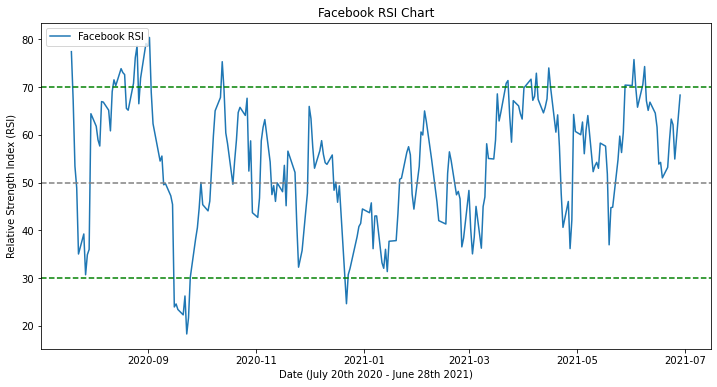

In [15]:
plt.figure(figsize=(12, 6))
plt.title('Facebook Stock Prices Chart')
plt.plot(fb_stock.index, fb_stock['Adj Close'], alpha=0.6)
plt.scatter(fb_stock.index, fb_stock['Buy'], color='green', marker='^')
plt.scatter(fb_stock.index, fb_stock['Sell'], color='red', marker='v')
plt.legend(['Facebook', 'Buy', 'Sell'], loc='upper left')
plt.xlabel('Date (July 20th 2020 - June 28th 2021)')
plt.ylabel('Adjusted Close Price ($)')
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Facebook RSI Chart')
plt.plot(fb_rsi)
plt.legend(['Facebook RSI'], loc='upper left')
plt.xlabel('Date (July 20th 2020 - June 28th 2021)')
plt.ylabel('Relative Strength Index (RSI)')
plt.axhline(30, linestyle='dashed', color='green')
plt.axhline(50, linestyle='dashed', color='grey')
plt.axhline(70, linestyle='dashed', color='green')


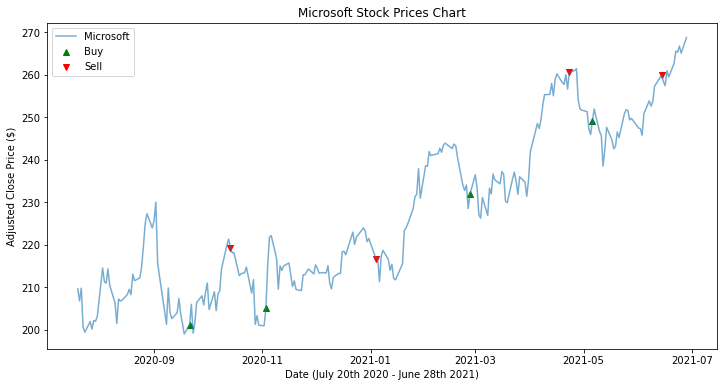

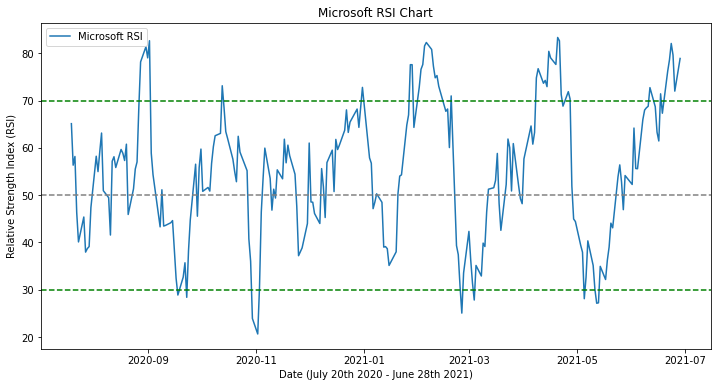

In [16]:
plt.figure(figsize=(12, 6))
plt.title('Microsoft Stock Prices Chart')
plt.plot(msft_stock.index, msft_stock['Adj Close'], alpha=0.6)
plt.scatter(msft_stock.index, msft_stock['Buy'], color='green', marker='^')
plt.scatter(msft_stock.index, msft_stock['Sell'], color='red', marker='v')
plt.legend(['Microsoft', 'Buy', 'Sell'], loc='upper left')
plt.xlabel('Date (July 20th 2020 - June 28th 2021)')
plt.ylabel('Adjusted Close Price ($)')
plt.show()

plt.figure(figsize=(12, 6))
plt.title('Microsoft RSI Chart')
plt.plot(msft_rsi)
plt.legend(['Microsoft RSI'], loc='upper left')
plt.xlabel('Date (July 20th 2020 - June 28th 2021)')
plt.ylabel('Relative Strength Index (RSI)')
plt.axhline(30, linestyle='dashed', color='green')
plt.axhline(50, linestyle='dashed', color='grey')
plt.axhline(70, linestyle='dashed', color='green')
